# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение моделей машинного обучения из библиотеки sklearn.

### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков (лучше выполнять действия сразу для двух датасетов)
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # дописать документация
    Выводить R2 и строит графики для оценки качества модели
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'E:/Python/Курс Библиотеки/project_task/project_task/train.csv' # y_train, y_valid
TEST_DATASET_PATH = 'E:/Python/Курс Библиотеки/project_task/project_task/test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [8]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Приведение типов

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [11]:
# чтобы не забыть обработать эти категориальные признаки
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Обзор данных

**Целевая переменная**

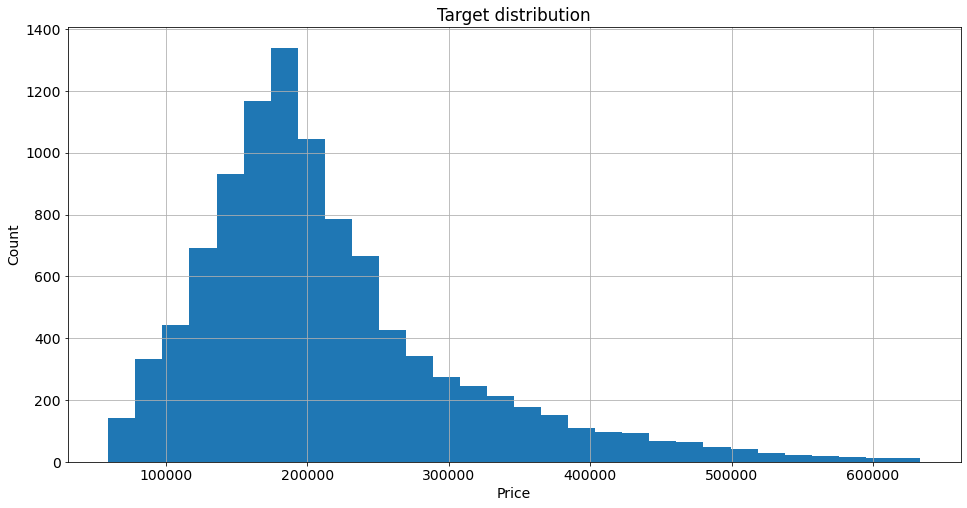

In [12]:
# логнормальное распределение
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [13]:
# много странностей и выбросов
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Категориальные переменные**

In [14]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [15]:
# перекос в данных, возможно, они не будут очень полезными
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



### Обработка выбросов

**Rooms**

In [16]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [17]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = int(train_df['Rooms'].median())

**Square, LifeSquare, KitchenSquare**

In [18]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [19]:
# типовые квантили для выбросов
# 1 99
# 2.5 97.5
# 5 95
# 10 90

In [20]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

In [21]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8881.000000,8881.000000,7296.000000,8881.000000,8881.000000,8881.000000,8.881000e+03,8881.000000,8881.000000,8881.000000,8881.000000,4799.000000,8881.000000,8881.000000,8881.000000
mean,1.884585,54.809487,34.830304,6.075329,8.446684,12.826934,4.242532e+03,0.119620,26.071163,5630.480014,8.403783,1156.072932,1.392636,4.438577,214939.479049
std,0.797003,16.225349,14.280535,3.503611,5.133763,6.369206,2.127571e+05,0.119654,17.269698,3977.902810,24.295214,1032.814421,1.492092,4.837340,89654.209673
min,1.000000,29.719934,2.941437,1.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.637555,22.863805,1.000000,4.000000,9.000000,1.972000e+03,0.017647,10.000000,2370.000000,0.000000,325.000000,0.000000,1.000000,156934.440088
50%,2.000000,51.656012,32.459931,6.000000,7.000000,14.000000,1.977000e+03,0.075779,25.000000,5562.000000,2.000000,990.000000,1.000000,3.000000,194240.534503
75%,2.000000,64.720916,44.119769,9.000000,12.000000,17.000000,2.000000e+03,0.194489,36.000000,7614.000000,5.000000,1548.000000,3.000000,6.000000,250381.580780
max,6.000000,117.855969,88.381356,14.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [22]:
# такие примеры разбросаны по всему датасету, не видно зависимости
mask = train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]
train_df.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,250.000000,652.000000,652.000000,652.000000
mean,1.648773,53.937687,53.975295,4.766871,9.946319,14.760736,2000.834356,0.107157,16.115031,3707.608896,9.110429,889.080000,0.878834,3.461656,190942.451129
std,0.735922,14.718972,14.697441,4.290268,5.805755,8.616302,19.706764,0.109550,16.929164,3944.012120,29.387084,723.285122,1.344859,5.290638,85871.143763
min,1.000000,29.719934,22.892380,1.000000,1.000000,0.000000,1918.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59877.592523
25%,1.000000,41.318307,41.593619,1.000000,5.000000,10.000000,1977.000000,0.011654,2.000000,629.000000,0.000000,540.000000,0.000000,0.000000,132108.091249
50%,1.000000,51.306312,50.900047,1.000000,9.000000,17.000000,2015.000000,0.072158,6.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,171791.694650
75%,2.000000,64.653077,64.342662,10.000000,14.000000,17.000000,2017.000000,0.195781,26.000000,6138.000000,4.000000,1046.000000,2.000000,5.000000,228633.695836
max,5.000000,89.118209,88.381356,14.000000,28.000000,117.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,4508.000000,6.000000,23.000000,573539.701956


In [23]:
# цифры по личному мнению, можно поставить свои
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [24]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

**HouseFloor, Floor**

In [25]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        39.,  40.,  44.,  45.,  48.,  99., 117.])

In [26]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 42],
      dtype=int64)

In [27]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [28]:
np.random.seed(27)
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index
print(len(floor_outliers))

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)

1404


**HouseYear**

In [29]:
train_df['HouseYear'].value_counts().sort_index()

1914          1
1916          1
1917          3
1918          4
1919          3
           ... 
2018        136
2019         57
2020         18
4968          1
20052011      1
Name: HouseYear, Length: 95, dtype: int64

In [30]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### Обработка пропусков

In [31]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1585
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4082
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [32]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981561,29.442751,6.0
1,65.683640,40.049543,8.0
3,53.352981,52.731512,9.0
4,39.649192,23.776169,7.0
5,80.384479,46.683720,12.0
6,62.254114,37.160377,7.0
8,64.511437,NaN,3.0
9,46.461409,18.915552,8.0
10,46.304907,27.922584,6.0
11,68.808859,45.736906,7.0


**LifeSquare**

In [33]:
train_df['LifeSquare'].median()

32.4599308684466

In [34]:
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.490551802890101

In [35]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [36]:
train_df['LifeSquare'].median()

33.273699979715275

**Healthcare_1**

In [37]:
train_df['Healthcare_1'].head()

0       NaN
1     240.0
3    1084.0
4    2078.0
5     990.0
Name: Healthcare_1, dtype: float64

In [38]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### Построение новых признаков

**Dummies**

In [39]:
train_df["Ecology_2"]

0       B
1       B
3       B
4       B
5       B
       ..
9995    B
9996    B
9997    B
9998    B
9999    B
Name: Ecology_2, Length: 8881, dtype: object

In [40]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

**DistrictSize, IsDistrictLarge**

In [41]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

# VC ~ размерность датасета, а она может быть другой на тесте

# VC(train + test)
# VC(normalize=True)
# VC(train).to_dict() -> train.map(dict), test.map(dict)
district_size.head()

,DistrictId,DistrictSize
0,27,628
1,1,537
2,23,449
3,6,396
4,9,279


In [42]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,990.0,0,11,B,184966.930730,1,1,1,20
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,86
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,146
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,95
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,4,990.0,0,6,B,215898.447742,1,1,1,54


In [43]:
(train_df['DistrictSize'] > 100).value_counts()

False    4938
True     3943
Name: DistrictSize, dtype: int64

In [44]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,990.0,0,11,B,184966.930730,1,1,1,20,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,240.0,1,16,B,300009.450063,1,1,1,86,0
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,B,175616.227217,1,1,1,146,1
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,B,150226.531644,1,1,1,95,0
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,990.0,0,6,B,215898.447742,1,1,1,54,0


In [70]:
# влияет ли признак на целевую переменную - да, влияет
train_df.groupby(['IsDistrictLarge'])['Price'].mean()

IsDistrictLarge
0    243569.228226
1    179085.129205
Name: Price, dtype: float64

**MedPriceByDistrict**

In [45]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,147258.736617
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146154.352249
4,1,2.0,202944.331497


In [46]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,20,0,203384.328026
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,86,0,300009.450063
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,146,1,169246.115943
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,95,0,158791.017955
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,0,6,B,215898.447742,1,1,1,54,0,384517.540046


*Пример переноса признака на test*

In [47]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [48]:
test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          3959 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        2623 non-null   float64
 16  Helthc

In [49]:
train_df.Ecology_2

0       B
1       B
2       B
3       B
4       B
       ..
8876    B
8877    B
8878    B
8879    B
8880    B
Name: Ecology_2, Length: 8881, dtype: object

In [50]:
train_df.Ecology_3

0       B
1       B
2       B
3       B
4       B
       ..
8876    B
8877    B
8878    B
8879    A
8880    B
Name: Ecology_3, Length: 8881, dtype: object

In [51]:
# train_df.Ecology_2 + train_df.Ecology_3

In [52]:
train_df["Eco2_Eco3"] = train_df.Ecology_2 + train_df.Ecology_3
train_df.groupby(["Floor"])["Rooms"].mean()

Floor
1     1.811671
2     1.911901
3     1.885781
4     1.966443
5     1.882850
6     1.881356
7     1.959807
8     1.898990
9     1.915058
10    1.818428
11    1.815789
12    1.762533
13    1.842466
14    1.894928
15    1.886463
16    1.840708
17    1.891304
18    1.982143
19    1.836735
20    1.886364
21    1.729730
22    2.142857
23    2.000000
24    1.800000
25    2.272727
28    1.500000
31    1.000000
32    1.000000
33    1.000000
42    2.000000
Name: Rooms, dtype: float64

In [53]:
gp = train_df.Ecology_2 + train_df.Ecology_3
gp.value_counts()

BB    8525
BA     267
AB      89
dtype: int64

### Отбор признаков

In [54]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'Eco2_Eco3']

In [55]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

In [56]:
train_df.shape

(8881, 27)

In [57]:
# надо все преобразования трейна перенести на тест, лучше классом/функцией
test_df.shape

(5000, 19)

### Разбиение на train и test

In [58]:
train_df["Rooms_vc"] = train_df["Rooms"].map(train_df["Rooms"].value_counts().to_dict())
train_df["Rooms_vc"]

0       3537
1       1973
2       3537
3       3250
4       1973
        ... 
8876    3537
8877    3250
8878    3250
8879    3537
8880    3250
Name: Rooms_vc, Length: 8881, dtype: int64

In [59]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [60]:
# валидация на отложенной выборке
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

### Построение модели

**Обучение и оценка модели**

In [61]:
rf_model = RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500, n_jobs=-1, random_state=39)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500,
                      n_jobs=-1, random_state=39)

**Отложенная выборка**

Train R2:	0.777
Test R2:	0.682


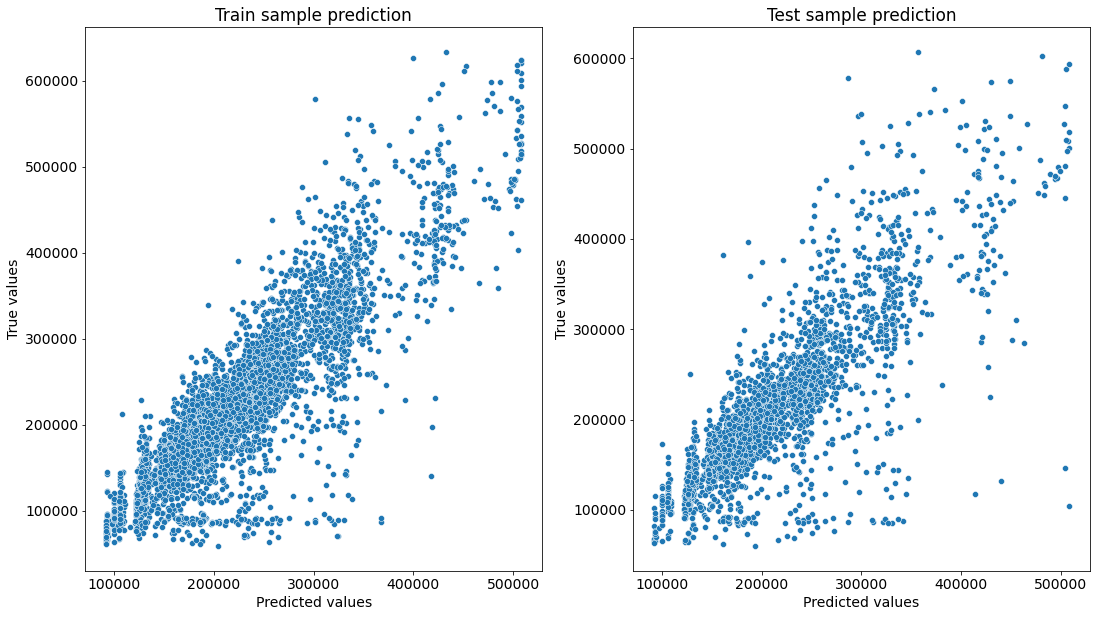

In [62]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#Train R2:	0.967 при max_depth=12
#Test R2:	0.696 - на тесте переобученная модель может деградировать сильнее
# ~ 10% желательно должно отличаться, иначе это переобучение

**Перекрёстная проверка**

In [63]:
cv_score = cross_val_score(
    rf_model,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.69448533, 0.68117969, 0.74073769, 0.73042016, 0.75026803])

In [64]:
cv_score.mean(), cv_score.std()

(0.7194181818500247, 0.026874181042790855)

In [65]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.6925440008072339, 0.7462923628928155)

**Важность признаков**

In [66]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceByDistrict,0.807825
1,Square,0.110282
3,KitchenSquare,0.015829
12,Social_3,0.014442
11,Social_2,0.008450
5,HouseFloor,0.008164
10,Social_1,0.007571
13,Healthcare_1,0.006214
6,HouseYear,0.005564
2,LifeSquare,0.003403


## Формирование файла с прогнозами

In [67]:
# ЗДЕСЬ НЕПРАВИЛЬНЫЕ ОТВЕТЫ! ПОДУМАЙТЕ, ГДЕ ОШИБКА И КАК ИСПРАВИТЬ
test_id = test_df["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = np.random.randint(0, 1e6, size=test_id.shape[0])
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv("./predictions_.csv", index=False)

In [68]:
pred_df = pd.read_csv("./predictions_.csv")
pred_df.head(n=2)

,Id,Price
0,725,791571
1,15856,380600


In [69]:
test_df.shape[0]

5000